# IFU Data Modeling


**Use case:** continuum and emission-line modeling of AGN; 1.47-1.87um.<br>
**Data:** [NIFS](https://www.gemini.edu/instrumentation/current-instruments/nifs) on Gemini; NGC 4151.<br>
**Tools:**  specutils, jdaviz/cubeviz, astropy, matplotlib, bottleneck.<br>
**Cross-intrument:** NIRSpec; potentially MIRI <br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis) and can be [downloaded](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/IFU_cube_continuum_fit/) directly from the [JDAT Notebook Github directory](https://github.com/spacetelescope/jdat_notebooks).<br>

## Introduction

This notebook uses an example 3-D IFU Datacube of the Active Galactic Nucleii NGC 4151 [Storchi-Bergmann et al. 2009,  MNRAS, V 394, pp. 1148-1166](https://ui.adsabs.harvard.edu/abs/2009MNRAS.394.1148S/abstract).  This is a ground-based AO-fed H-band dataset (1.47-1.87um) from the Near-Infrared Integral Field Spectrograph (NIFS) instrument at the Gemini Observatory.  NIFS is a very similar image slicing IFU to JWST NIRSpec.

This notebook performs some simple spectral investigations.  The notebook utilizes [jdaviz/cubviz](https://github.com/spacetelescope/jdaviz) to inspect the dataset and extract 1-D spectra.  The continuum is fit in a region near to the 1.644um [Fe II] emission from the AGN outflow and subtracted.  The centrally compact atomic Hydrogen Brackett 12 feature, which is nearby in wavelength and contaminates the [Fe II] outflow emission, is also fit and removed.  The data sub-cubes of the continuum model and the isolated and continuum subtracted [Fe II] emission are then saved.  These saved data sets will ultimately serve as starting points for the future notebooks in this set.

**Note:** This notebook is designed to analyze the 1.6440 [Fe II] emission but the wavelengths can be altered to fit and remove continuum around any emission line of interest.

## Import Packages
 - time for timing
 - numpy for array processing and math
 - matplotlib.pyplot for plotting images and spectra
 - astropy.io for reading and writing FITS cubes and images
 - astropy.modeling for modeling spectral curves
 - astropy.utils.data for accessing the data
 - specutils.fitting for spectral data fitting
 - specutils Spectrum1D for modeling emission lines
 - jdaviz.app to use cubeviz in the notebook



In [16]:
# load important packages
import time
from copy import copy

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy import units as u
from astropy.modeling import models
from astropy.utils.data import download_file
from specutils.fitting import fit_lines
from specutils import Spectrum1D

from jdaviz.app import Application

from IPython.display import HTML


In [6]:
# load and configure matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})


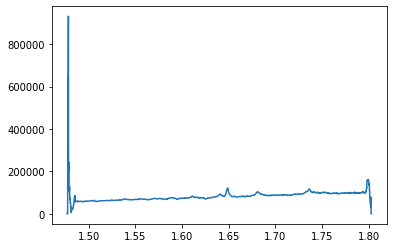

In [7]:
#This cell accesses the datacube file, defines the wavelength grid from header information and then plots a simple
# 1-D collapsed spectrum of the IFU data.

# Read in a 3-D IFU datacube of interest, and header.
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits', cache=True)
cube = fits.getdata(cube_file)
header_cube = fits.getheader(cube_file)

#grab data information and wavelength definitions.
nz, ny, nx = cube.shape
crdelt3 = header_cube['CDELT3']
crval3 = header_cube['CRVAL3']

#define the wavelength grid (microns) from the header (Angstroms)
# and the AGN redshift and the emission line of interest.
wave =((crdelt3 * (np.arange(0,nz,1))) + crval3)/10000.0
redshift = 0.00332
emission_line = 1.64400*(1 + redshift)
emission_line_index = (np.abs(wave-emission_line)).argmin()

# make a simple summed 1d spectrum of the full cube
flux1 = np.sum(cube, axis=(1,2))

# plot the full 1-D spectrum.
plt.figure(0)
plt.plot(wave, flux1)
plt.show()


We see that the spectral edges of the summed 1D are 'ratty'.  The 1D spectral array goes beyond the nominal useable data range of the instrument.  We'll ignore the poor spectral regions and focus on the AGN flux.

The [Fe II] feature that we are interested in is the bright, strong emission just shortward of 1.65um.  The contaminating H I Br 12 emission is just blueward of the [Fe II].

We can use this plot window to read wavelength values of interest to define our analysis spectral ranges (see wavelength/flux grid data to the lower right of the plot window).

Special Note - in this particular dataset, a portion of the spectrum on the red side of the [FeII] emission
provides a clean measure of the continuum.  The blue-ward side of the [Fe II]
and HI Brackett 12 emission has other emission and absorption features that make clear continuum ID very 
difficult.  As a result, it is more accurate to do a simple linear fit to the red side of the spectrum rather than
a more expanded spectral region that encompasses the emission..

In [ ]:

#This cell defines the wavelength regions of interest: around the emission line, and the location
#where you want to fit and remove the continuum very accurately.  Make a plot that shows the regions.

# Here we select a region that includes the emission line
# wavelength plus a small range of continuum around it.  
# Determine these limits by investigating the flux in the above plot.  Read
# the wavelength values off of the plot information at the lower right.

wave_emission_limit1 = 1.630
wave_emission_limit2 = 1.665

# Here we define a spectral range where we will use the
# flux to generate a continuum model.  The flux shape in this
# AGN is quite linear around the redward emission, so we will use only a 
# short segment of the spectrum on the red side of the emission 
# feature.
# We again determine these values by investigating the wavelengths in the
# above plot window.

continuum_limit1 = 1.656
continuum_limit2 = 1.673
  
#Define the wavelength region around the emission - indices
wavemin = (np.abs(wave-wave_emission_limit1)).argmin()
wavemax = (np.abs(wave-wave_emission_limit2)).argmin()

# Define the wavelength region used to fit the continuum flux level  - indices.
continuummin = (np.abs(wave-continuum_limit1)).argmin()
continuummax = (np.abs(wave-continuum_limit2)).argmin()

#show the region used for the emission line and continuum fit.  Alter the wavelengths 
# above if this doesn't look good.  
plt.figure(1)
plt.plot(wave, flux1)
plt.plot(wave[wavemin:wavemax], flux1[wavemin:wavemax])
plt.plot(wave[continuummin:continuummax], flux1[continuummin:continuummax],color='r')
plt.show()


In [ ]:
print(wave)
#print(wave-wave_emission_limit1)
#print(continuummin,continuummax)

 For this particular dataset, this continuum region looks very good.
 if you have a more structured continuum you can define additional
 regions and append them into a larger set of wave / flux arrays to 
 derive a more accurate fit in the below poly-fit analysis.

### Cubeviz Visualization
You can also visualize images inside a Jupyter notebook using [Cubeviz](https://jdaviz.readthedocs.io/en/latest/cubeviz/index.html)

### Video1: 

YouTube Demo

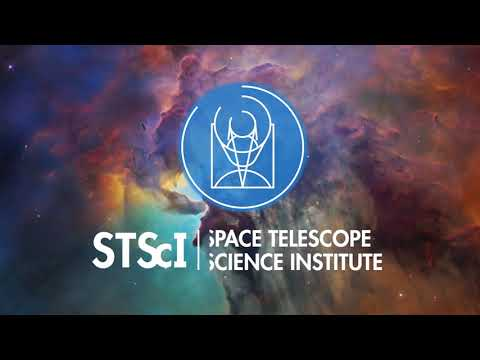

In [18]:
from IPython.display import YouTubeVideo
vid = YouTubeVideo("HMSYwiH3Gl4")
display(vid)

In [ ]:
from jdaviz import CubeViz
cubeviz = CubeViz()
cubeviz.app

In [ ]:
# Here, we load the data into the cubeviz app.
cubeviz.load_data(fn) 

### Some Notes:

*If your cell window requires you to scroll to see the different displays in cubeviz, you can toggle the scroll window in the main menu of the notebook: Cell -> Current Outputs -> Toggle Scrolling

*In the datacube viewing panel, you can select the 'layer' tab (horizontal line settings icon) in the upper panel within the viewer and change the display scaling.  Decreasing the maximum display value by 10x brings out the low level extended emission in this dataset.  In this cube, data from slice ~1060 to ~1090 shows the extended [Fe II] emission.  

### Video2: 

Here is a video illustrating how to load and manipulate data for this particular notebook.

In [25]:
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/cubeviz1.mov" frameborder="0" allowfullscreen></iframe>')


### Video3:

Here is a video illustrating how to define your regions of interest and extract them into the notebook for more analysis below.

In [26]:
#PART 1
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/cubeviz2_1.mov" frameborder="0" allowfullscreen></iframe>')

In [27]:
#PART 2
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/cubeviz2_2.mov" frameborder="0" allowfullscreen></iframe>')


# Extract Subset Spectrum in Cubeviz Spectrum Viewer

Retrieve the spectrum (Subset1) of the user-defined region from the Spectrum Viewer as a Spectrum1D object.

In [ ]:
#Extract spectra corresponding to the colored regions in cubeviz
spectrum1 = cubeviz.app.get_data_from_viewer('spectrum-viewer','Subset 1') #AGN Center
spectrum2 = cubeviz.app.get_data_from_viewer('spectrum-viewer','Subset 2') #Red shifted component
spectrum3 = cubeviz.app.get_data_from_viewer('spectrum-viewer','Subset 3') #Blue shifted component
#spectrum3 = cubeviz.app.get_data_from_viewer('spectrum-viewer')['Subset 3'] #Blue shifted component
spectrum1

In [ ]:
#regions = cubeviz.specviz.get_spectral_regions()
#regions

In [ ]:
#regions = cubeviz.app.get_data_from_viewer('flux-viewer')['Subset 4'] #AGN Center
#regions

In [ ]:
#regions = cubeviz.app.get

In [ ]:
#Extract the spectral regions defined in the spectral viewer
from specutils.spectra import SpectralRegion
regions = cubeviz.specviz.get_spectral_regions()
regions

line_region = regions["Subset 4"]
continuum_region = regions["Subset 5"]

In [ ]:
#Define Missing Spectral Regions if User Did Not in Cubeviz
if not regions:
    line_region = SpectralRegion(1.630*u.um, 1.665*u.um)
    
if not regions:
    continuum_region = SpectralRegion(1.656*u.um, 1.673*u.um)

In [ ]:
#Apply the spectral region
from specutils.manipulation import extract_region

if not spectrum1:
    flux_agn = np.sum(cube[:,(ny//2)-3:(ny//2)+3,(nx//2)-3:(nx//2)+3], axis=(1,2))
    tmpspec = Spectrum1D(flux=flux_agn*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_agn = extract_region(tmpspec, line_region)
    spec_agn_continuum = extract_region(tmpspec, continuum_region)
else: 
    spec_agn = extract_region(spectrum1, line_region)
    spec_agn_continuum = extract_region(spectrum1, continuum_region)

if not spectrum2:
    flux_feii_red = np.sum(cube[:,(36)-3:(36)+3,(12)-3:(12)+3], axis=(1,2))
    tmpspec = Spectrum1D(flux=flux_feii_red*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_feii_red = extract_region(tmpspec, line_region)
    spec_feii_red_continuum = extract_region(tmpspec, continuum_region)
else:    
    spec_feii_red = extract_region(spectrum2, line_region)
    spec_feii_red_continuum = extract_region(spectrum2, continuum_region)

if not spectrum3:
    flux_feii_blue = np.sum(cube[:,(28)-3:(28)+3,(50)-3:(50)+3], axis=(1,2))
    tmpspec = Spectrum1D(flux=flux_feii_blue*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_feii_blue = extract_region(tmpspec, line_region)
    spec_feii_blue_continuum = extract_region(tmpspec, continuum_region)
else:     
    spec_feii_blue = extract_region(spectrum3, line_region)
    spec_feii_blue_continuum = extract_region(spectrum3, continuum_region)

In [ ]:
#Visualize new subsets
plt.figure()
plt.plot(spec_agn.spectral_axis,spec_agn.flux,color='black')

In [ ]:
#Visualize new subsets
plt.figure()
plt.plot(spec_feii_blue.spectral_axis,spec_feii_blue.flux,color='b')
plt.plot(spec_feii_red.spectral_axis,spec_feii_red.flux,color='r')

In [28]:
#EDITOR NOTE, LIST HERE DIFFERENT VIEWERS
#Now fit the continuum in Cubeviz

#PART 1
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/bestfitcube_p1.mov" frameborder="0" allowfullscreen></iframe>')

In [29]:
#PART 2
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/bestfitcube_p2.mov" frameborder="0" allowfullscreen></iframe>')

In [ ]:
#List Data from Viewer
regions = cubeviz.app.get_data_from_viewer("uncert-viewer")
regions

In [ ]:
#Extract Continuum Model from Cubeviz above
cont_psf_cube = cubeviz.app.get_data_from_viewer("uncert-viewer", "LinFitCont [Cube] 1")
#cont_psf_cubee = cubeviz.app.get_data_from_viewer("uncert-viewer", "LinFitCont [Cube] 2")

## Important Note: Always save data and variables when possible.

In [ ]:
#Subtract Continuum

#Re-read in original IFU cube for manipulation
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
newfn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits', cache=True)
newheader_cube = fits.getheader(cube_file)

#Delete any existing output in current directory
import os
if os.path.exists("NGC4151_Hband_ContinuumSubtract.fits"):
  os.remove("NGC4151_Hband_ContinuumSubtract.fits")
else:
  print("The file does not exist")

import os
if os.path.exists("NGC4151_Hband_ContinuumPSF.fits"):
  os.remove("NGC4151_Hband_ContinuumPSF.fits")
else:
  print("The file does not exist")

#Check to see if user made a continuum fit in Cubeviz, make continuum subtraction, and save output
if not cont_psf_cube:
    start_time = time.time()

    cont_sub_cube=np.zeros([nz,ny,nx])
    cont_psf_cube=np.zeros([nz,ny,nx])

    for i in range(1, nx-2):
        for j in range(1, ny-2):
            flux1 = cube[:,j,i]      
            cont_fit = np.polyfit(wave[continuummin:continuummax], flux1[continuummin:continuummax], 1)
            fitval = np.poly1d(cont_fit)
            continuum = fitval(wave)        
            cont_sub_cube[:,j,i]= flux1 - continuum
            cont_psf_cube[:,j,i]= continuum 

    del newheader_cube['MODE']
    fits.writeto('NGC4151_Hband_ContinuumSubtract.fits', cont_sub_cube, newheader_cube, overwrite=True)
    fits.writeto('NGC4151_Hband_ContinuumPSF.fits', cont_psf_cube, newheader_cube, overwrite=True)
    print('Continuum subtracted cube saved. PSF continuum cube saved.')
else:
    with fits.open(newfn, memmap=False) as cont_sub_cube:
        sci = cont_sub_cube['SCI'].data

        #Get List of different viewers
        #linfitcube = cubeviz.app.get_data_from_viewer("uncert-viewer", "LinFitCube [Cube] 1")
        continuumflux = cont_psf_cube["flux"]

        sci_contsub = sci-continuumflux
        cont_sub_cube['SCI'].data = sci_contsub 
        #cubeviz.app.load_data(newcube)
        #del newheader_cube['MODE']
        del cont_sub_cube['PRIMARY'].header['MODE']
        cont_sub_cube.writeto('NGC4151_Hband_ContinuumSubtract.fits')
        del newheader_cube['MODE']
        fits.writeto('NGC4151_Hband_ContinuumPSF.fits', continuumflux, newheader_cube, overwrite=True)

In [ ]:
#You can also read out your model fit parameters 
params=cubeviz.get_model_parameters(model_label="LinFitCont")
params

In [ ]:
#And this is how you can acces the model fits
params['LinFitCont_3d']['slope']

In [ ]:
#Open up a new instance of Cubeviz to visualize continuum subtracted data
from jdaviz import CubeViz
cubeviz2 = CubeViz()
cubeviz2.app

In [ ]:
cont_sub_cube = 'NGC4151_Hband_ContinuumSubtract.fits'
cubeviz2.app.load_data(cont_sub_cube, data_label='Continuum Subtracted')

In [30]:
# Now we want to investigate an initial fit to the
# Br 12 emission feature, which is a pesky contaminant nearby in wavelength
# to our target [Fe II] emission.  The Br 12 is centrally compact and arises from
# only from the nucleus of the AGN, not from the outflow.  Make a plot of the fit
# results.

#PART1

HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/multifit_p1.mov" frameborder="0" allowfullscreen></iframe>')

In [32]:
#PART2
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/multifit_p2.mov" frameborder="0" allowfullscreen></iframe>')


In [ ]:
# Wow, that multi-component fit looks great.  Good deal.

# Now we're going to use the continuum psf cube from a prior cell 
# with the Brackett model created in the above cell to create a full
# 3-D model of the central emission that isn't caused by the outflow [Fe II].

#Extract the spectral regions defined in the spectral viewer
regions = cubeviz2.specviz.get_spectral_regions()
regions

line_region = regions["Subset 1"]

In [ ]:
spec=cubeviz2.app.get_data_from_viewer('spectrum-viewer') #AGN Center
spec

In [ ]:
#Get Gauss Model Spectrum and Model Cube
all_spec = cubeviz2.app.get_data_from_viewer('spectrum-viewer','Continuum Subtracted[SCI]') #AGN Center Data Cube
gauss_spec = cubeviz2.app.get_data_from_viewer('spectrum-viewer','GaussAll') #AGN Center Model Spec
gauss_cube = cubeviz2.app.get_data_from_viewer("uncert-viewer", "GaussAll [Cube] 1") #AGN Center Model Cube

In [ ]:
#You can also read out your model fit parameters 
params=cubeviz2.get_model_parameters(model_label="GaussAll")
params

In [ ]:
#Overwrite Gauss Model with only 2 of the components of interest
gauss_cube_2component = gauss_cube["flux"]*0
from astropy.modeling import models

nz, ny, nx = gauss_cube_2component.shape
for i in range(0, nx-1):
    for j in range(0, ny-1):
        amp1=params['GaussAll_3d']['amplitude_0'][i][j]
        amp2=params['GaussAll_3d']['amplitude_2'][i][j]
        m1=params['GaussAll_3d']['mean_0'][i][j]
        m2=params['GaussAll_3d']['mean_2'][i][j]
        stdev1=params['GaussAll_3d']['stddev_0'][i][j]
        stdev2=params['GaussAll_3d']['stddev_2'][i][j]
        g1 = models.Gaussian1D(amplitude=amp1*u.Unit('count'), mean=m1*u.m, stddev=stdev1*u.m)
        g2 = models.Gaussian1D(amplitude=amp2*u.Unit('count'), mean=m2*u.m, stddev=stdev2*u.m)
        gauss_cube_2component[:,i,j] = g1(all_spec.spectral_axis)+g2(all_spec.spectral_axis)

In [ ]:
#Add the continuum cube to the new model cube
continuum_file = 'NGC4151_Hband_ContinuumPSF.fits'
newfull_header = fits.getheader(continuum_file)
with fits.open(continuum_file, memmap=False) as continuum_cube: 
    #print(continuum_cube[0].data)
    continuum_data = continuum_cube[0].data
    full_model = gauss_cube_2component+continuum_data

In [ ]:
# subtract the model to create the final cube where the [Fe II] emission is isolated.
#Re-read in original IFU cube for manipulation
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
newfinalsub_header = fits.getheader(cube_file)
with fits.open(cube_file, memmap=False) as original_cube: 
    original_data = original_cube['SCI'].data
    final_sub_cube = original_data - full_model

In [ ]:
#Delete any existing output in current directory
import os
if os.path.exists("NGC4151_Hband_FinalSubtract.fits"):
  os.remove("NGC4151_Hband_FinalSubtract.fits")
else:
  print("The file does not exist")

import os
if os.path.exists("NGC4151_Hband_ContinuumandBrackettModel.fits"):
  os.remove("NGC4151_Hband_ContinuumandBrackettModel.fits")
else:
  print("The file does not exist")

In [ ]:
#del newfull_header['MODE']
del newfinalsub_header['MODE']
fits.writeto('NGC4151_Hband_ContinuumandBrackettModel.fits', full_model, newfull_header, overwrite=True)
fits.writeto('NGC4151_Hband_FinalSubtract.fits', final_sub_cube, newfinalsub_header, overwrite=True)
print('Continuum subtracted cube saved. PSF continuum cube saved.')

In [ ]:
#Make the final plots to illustrated
plt.figure()
plt.xlim([1.630E-6, 1.665E-6])
plt.ylim([600, 900])
plt.plot(all_spec.spectral_axis, continuum_data[:,30,30],label='Continuum')
plt.plot(all_spec.spectral_axis, original_data[:,30,30],label='Original Data')
plt.plot(all_spec.spectral_axis, full_model[:,30,30],label='2 Component Model')
plt.plot(all_spec.spectral_axis, final_sub_cube[:,30,30]+700,label='Model Subtraction+Offset')
plt.legend()
plt.show()

## Alternative Code in Case You Don't Use CubeViz

In [ ]:

# This cell builds the spectrum at the central location into the format
# needed for use with specutils.  It then investigates an initial fit to the
# Br 12 emission feature, which is a pesky contaminant nearby in wavelength
# to our target [Fe II] emission.  The Br 12 is centrally compact and arises from
# only from the nucleus of the AGN, not from the outflow.  Make a plot of the fit
# results.

#zoom in wavelength into the region of interest, create subcube and subwave arrays.
flux = (cont_sub_cube[wavemin:wavemax,30,30])
minwave = wave[wavemin:wavemax]

# put the flux spectrum into the spec utils expected format.
spectrum = Spectrum1D(flux=(flux)*u.Unit('count'), spectral_axis=minwave*u.micron)

#define the fit the line for the Brackett emission (position was found by hand @ pix 1023):
# the central emission is best fit by two gaussian components: one @ br12, one @ [Fe II].
# Here we fit a third component too: the [Fe II] outflow emission.
l1 = models.Gaussian1D(amplitude = (flux[1023-wavemin])*u.Unit('count'), mean = minwave[1023-wavemin]*u.micron, stddev = 0.0009*u.micron)
l2 = models.Gaussian1D(amplitude = (flux[emission_line_index-wavemin])*u.Unit('count'), mean = minwave[emission_line_index-wavemin]*u.micron, stddev = 0.005*u.micron)
#define and fit the line for the outflow [Fe II] emission:
l3 = models.Gaussian1D(amplitude = (flux[emission_line_index-wavemin])*u.Unit('count'), mean = minwave[emission_line_index-wavemin]*u.micron, stddev = 0.0008*u.micron)

#run the lfit - this tweaks the above parameters to optimize the fits of the three components.
lfit = fit_lines(spectrum, l1 + l2 + l3)
#make the yfit
y_fit = lfit(minwave*u.micron)

# Build the fits from the fit_lines function into specutils format for plotting.
lineflux = (lfit[0](minwave*u.micron))
linemodel = Spectrum1D(spectral_axis=minwave*u.micron, flux=lineflux*u.Unit('count'))

component1 = lfit[0](minwave*u.micron)
component2 = lfit[1](minwave*u.micron)
component3 = lfit[2](minwave*u.micron)

plt.figure(8)
plt.plot(minwave, flux)
plt.plot(minwave, component1)
plt.plot(minwave, component2)
plt.plot(minwave, component3)
plt.plot(minwave, component1 + component2 + component3)
plt.show()

#we want to isolate just the [Fe II] outflow emission, so subtract off the central compact flux sources
central_flux_model_only = component1 + component2



In [ ]:

# Wow, that multi-component fit looks great.  Good deal.

#now we're going to use the continuum psf cube from a prior cell 
# with the Brackett model created in the above cell to create a full
# 3-D model of the central emission that isn't caused by the outflow [Fe II].

continuum_subcube = cont_psf_cube[wavemin:wavemax,:,:]
nz, ny, nx = continuum_subcube.shape

model_cube=np.zeros([nz,ny,nx])

#construct the scaled Brackett flux model
model_cube[0,:,:] = continuum_subcube[0,:,:] * (central_flux_model_only[0]/continuum_subcube[0, 30, 30])
for i in range(1, nz-2):
    model_cube[i,:,:] = continuum_subcube[i,:,:] * (central_flux_model_only[i] / continuum_subcube[i, 30, 30])
model_cube[nz-1,:,:] = continuum_subcube[nz-1,:,:] * (central_flux_model_only[nz-1] / continuum_subcube[nz-1,30,30])

# the full model of the AGN central emission is the continuum plus Brackett line.
full_model = continuum_subcube + model_cube

# subtract the model to create the final cube where the [Fe II] emission
# is isolated.
final_sub_cube = cube[wavemin:wavemax,:,:] - full_model

# make an appropriate header for the output sub-cube
header_cube_small = copy(header_cube)
del header_cube_small['CRVAL3']
header_cube_small['CRVAL3'] = wave[wavemin] * 10000.0
del header_cube_small['CRPIX3']
header_cube_small['CRPIX3'] = 1

# Save the .fits data sub-cube that has the continuum and Br model subtracted off of the
# [Fe II] emission, and the datacube that is the continuum+Br model.
fits.writeto('NGC4151_Hband_FinalSubtract.fits', final_sub_cube, header_cube_small, overwrite=True)
fits.writeto('NGC4151_Hband_ContinuumandBrackettModel.fits', full_model, header_cube_small, overwrite=True)
print('Continuum and Brackett subtracted cube saved.  Full model cube saved.')

#make a plot of the central spectrum, the full model and the continuum.
plt.figure(9)
plt.plot(minwave, continuum_subcube[:,30,30])
#plt.plot(minwave, cube[wavemin:wavemax,30,30])
plt.plot(minwave, full_model[:,30,30])
plt.show()

